In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run: pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import sys
import matplotlib.ticker as mticker
import sectionate
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client
import glob
import cmocean.cm as cmo
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
sns.set_style("darkgrid")

print(f"Sectionate version: {sectionate.__version__}")
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

Sectionate version: 0.2.2
xgcm version 0.8.2.dev52+g5398098 
regionate version 0.3.3 
xwmt version 0.1.0 
xwmb version 0.3.0


In [3]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/" + x
datafiles = glob.glob(datadir("CM4Xp125*"))[20:]
datafiles = sorted(datafiles)

In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='75GB',
    walltime='03:00:00',
    queue='compute',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=6)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=70G
#SBATCH -t 03:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.96:43522 --name dummy-name --nthreads 36 --memory-limit 69.85GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.96:43522,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
def get_transports(ds):
    ds_sub = ds[["umo", "vmo", "thkcello", "sigma2_i", "zos"]]

    return ds_sub
    
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
ds = xr.open_mfdataset(
        datafiles,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        preprocess = get_transports, 
        engine="zarr")
ds["z"] = approximate_z_top_down(ds, dim = "sigma2")
ds = ds[["vmo", "z", "sigma2_i"]]
ds["z"] = ds["z"].sel(time = slice("1980", "2010")).mean("time").compute()

grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")

In [7]:
div_v = grid.diff(ds["vmo"].fillna(0.0), axis = "Y", boundary = "fill").fillna(0.0)

In [8]:
lats = np.arange(-80, 80, 1.5)
psi = meridional_streamfunction(grid, lats, div_v = div_v)

Computing z by latitude: 100%|██████████| 107/107 [00:11<00:00,  9.07it/s]


Text(0.5, 1.0, 'Global Meridional Streamfunction')

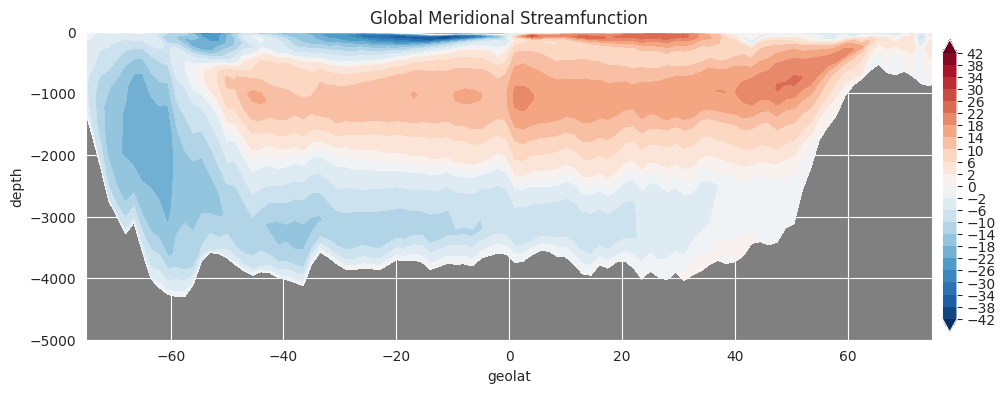

In [14]:
#define streamfunction levels
levels = [-42, -38, -34, -30, -26, -22, -18, -14, -10, -6, -2, 
           0,   2,   6,  10,  14,  18,  22,  26,  30,  34,  38,  42]

#select experiment 
exp = "control"

# create one figure with two subplots
fig, ax = plt.subplots(figsize=(13, 4), sharey=True)

# first subplot: depth
p1 = psi["psi"].sel(exp=exp).plot.contourf(
    ax=ax, x="geolat", y="depth", levels=levels,
    add_colorbar=False, cmap='RdBu_r', extend = "both"
)
c1 = fig.colorbar(p1, ax=ax, pad=0.01, spacing='uniform',
                  extend='both', shrink=0.95, orientation='vertical')
c1.set_ticks(levels)
c1.ax.tick_params(labelsize=10)
ax.set_facecolor('gray')
ax.set_xlim(-75, 75) #required for some reason 
ax.set_ylim(-5000, 0) #required for some reason 
# ax.invert_yaxis()
ax.set_title("Global Meridional Streamfunction")